In [214]:
import pandas as pd
from path import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [215]:
DATA_DIR = Path("/home/sharad/data/metasense/la/")

In [216]:
data = pd.read_csv(DATA_DIR / "all_data.csv", index_col='datetime', parse_dates=True)
data['temperature-F'] = 9.0 / 5.0 * data['temperature'] + 32

## Sanity Check

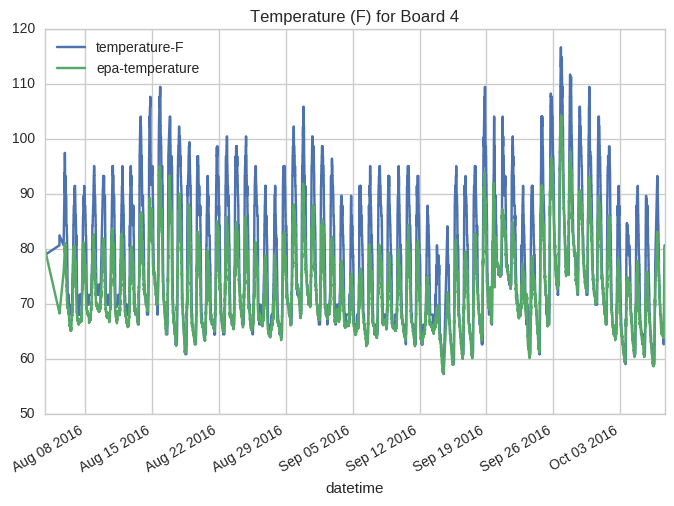

In [217]:
data[['temperature-F', 'epa-temperature']].plot()
plt.title("Temperature (F) for Board 4")
plt.show()

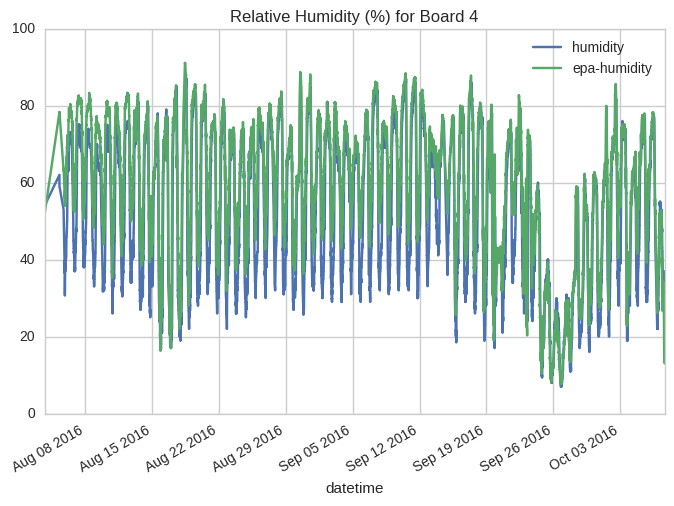

In [218]:
data[['humidity', 'epa-humidity']].plot()
plt.title("Relative Humidity (%) for Board 4")
plt.show()

# Training with board 4

Let's see how models perform. We'll train on the first two weeks and evaluate on the rest of the data.

In [219]:
train_data, test_data = data.loc[:"2016-08-18"], data.loc["2016-08-18":]
def benchmark(name, cf, features, output):
    cf.fit(train_data[features], train_data[output])
    error = np.sqrt((test_data[output] - cf.predict(test_data[features])) ** 2)
    print("%s: %f" % (name, error.mean()))
    return (name, error, cf, features)

BENCHMARKS = [
    ("Linear[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', LinearRegression())])),
    ("Linear[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', LinearRegression())])),
    ("Linear[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', LinearRegression())])),
    ("Ridge[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Ridge())])),
    ("Ridge[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Ridge())])),
    ("Ridge[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', Ridge())])),
    ("Lasso[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Lasso())])),
    ("Lasso[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])),
    ("Lasso[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', Lasso())])),
]
CO_FEATURES = (["co-A", "co-W", "temperature", "humidity"], "epa-co")
O3_FEATURES = (["o3-A", "o3-W", "co-A", "co-W", "temperature", "humidity"], "epa-o3")
NO2_FEATURES = (["o3-A", "o3-W", "no2-A", "no2-W", "co-A", "co-W", "temperature", "humidity"], "epa-no2")
def benchmark_full(features, output):
    results = {}
    best = (float('inf'), None)
    for name, cf in BENCHMARKS:
        results[name] = benchmark(name, cf, features, output)
        _, error, _, _ = results[name]
        avg_error = error.mean()
        if avg_error < best[0]:
            best = (avg_error, results[name])
    print_function(best[1])
    return best
def print_function(result):
    name, _, cf, features = result
    poly = cf.named_steps['poly']
    func = cf.named_steps['cf'].coef_
    print("f(x) = ", end="")
    terms = []
    for term in poly.powers_:
        polyterms = ["%s^%u" % (features[i], power) if power > 1 else "%s" % features[i] for i, power in enumerate(term) if power > 0]
        terms.append(" * ".join(polyterms))
    print(" + ".join(["%.2E * %s" % (c, t) for c, t in zip(func, terms) if c != 0.0]))

Linear[1]: 0.120369
Linear[2]: 0.083046
Linear[3]: 0.109547
Ridge[1]: 0.120369
Ridge[2]: 0.082423
Ridge[3]: 0.104180
Lasso[1]: 0.130756
Lasso[2]: 0.076485
Lasso[3]: 0.075617
f(x) = 4.38E-08 * co-W^2 + -3.46E-08 * co-A^3 + 6.48E-08 * co-A^2 * co-W + -1.88E-07 * co-A^2 * temperature + -4.19E-08 * co-A^2 * humidity + -4.33E-09 * co-A * co-W^2 + -1.15E-07 * co-A * co-W * temperature + 9.59E-09 * co-A * co-W * humidity + 5.80E-07 * co-A * temperature^2 + -1.89E-07 * co-A * temperature * humidity + -5.10E-08 * co-A * humidity^2 + 1.65E-11 * co-W^3 + 2.44E-09 * co-W^2 * temperature + -1.90E-09 * co-W^2 * humidity + 6.91E-09 * co-W * temperature^2 + 1.23E-07 * co-W * temperature * humidity + 1.02E-07 * co-W * humidity^2 + 1.71E-06 * temperature^3 + -1.61E-06 * temperature * humidity^2 + 4.03E-08 * humidity^3


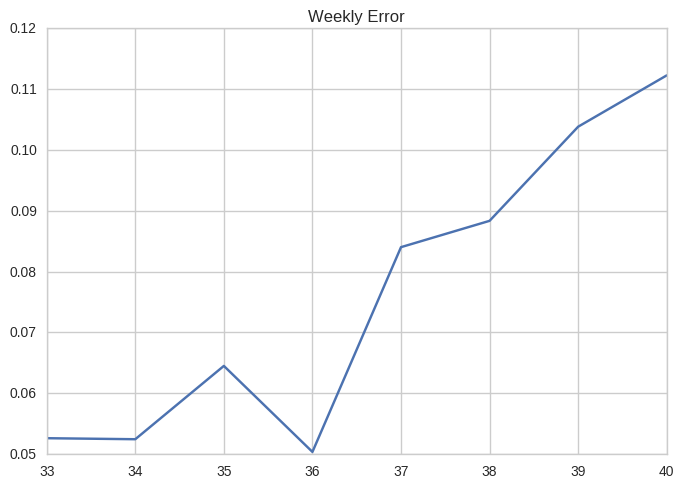

In [220]:
error, results = benchmark_full(*CO_FEATURES)
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
plt.show()

Linear[1]: 9.101336
Linear[2]: 11.755760
Linear[3]: 49.911461
Ridge[1]: 9.101386
Ridge[2]: 10.714223
Ridge[3]: 18.671871
Lasso[1]: 9.522306
Lasso[2]: 7.872711
Lasso[3]: 9.519874
f(x) = 1.02E-01 * co-W + -4.22E-04 * o3-A^2 + 1.54E-03 * o3-A * o3-W + -9.97E-04 * o3-A * co-A + -1.08E-04 * o3-A * co-W + 9.66E-03 * o3-A * temperature + 2.94E-04 * o3-A * humidity + -8.81E-04 * o3-W^2 + 1.92E-03 * o3-W * co-A + 3.50E-05 * o3-W * co-W + 1.13E-03 * o3-W * temperature + 4.03E-05 * o3-W * humidity + 3.53E-04 * co-A^2 + -7.67E-04 * co-A * co-W + -6.81E-03 * co-A * temperature + -2.10E-03 * co-A * humidity + -4.28E-06 * co-W^2 + -6.51E-04 * co-W * temperature + 7.49E-05 * co-W * humidity + -2.31E-02 * temperature^2 + 2.38E-02 * temperature * humidity + -2.88E-04 * humidity^2


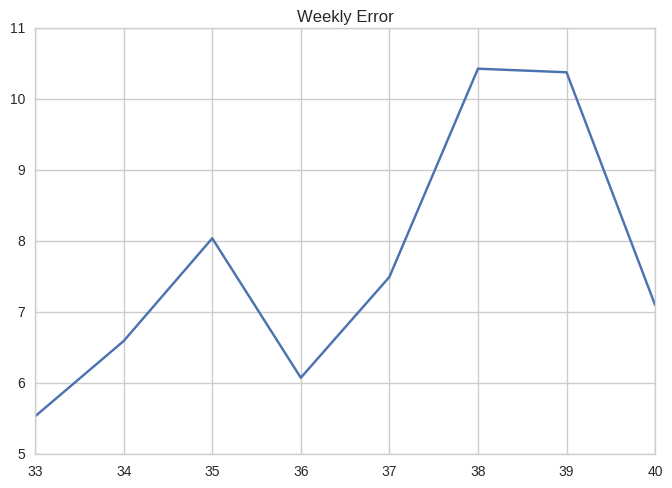

In [221]:
error, results = benchmark_full(*O3_FEATURES)
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
plt.show()

Linear[1]: 5.572207
Linear[2]: 5.447854
Linear[3]: 38.072343
Ridge[1]: 5.572243
Ridge[2]: 5.459094
Ridge[3]: 9.011886
Lasso[1]: 6.291841
Lasso[2]: 4.813447
Lasso[3]: 5.148992
f(x) = 1.55E-03 * o3-A^2 + -3.18E-04 * o3-A * o3-W + -6.36E-04 * o3-A * no2-A + 2.80E-04 * o3-A * no2-W + -1.08E-03 * o3-A * co-A + -2.12E-05 * o3-A * co-W + 1.02E-03 * o3-A * temperature + -1.93E-04 * o3-A * humidity + -3.14E-04 * o3-W^2 + -1.44E-04 * o3-W * no2-A + 9.33E-05 * o3-W * no2-W + -7.89E-04 * o3-W * co-A + -7.56E-05 * o3-W * co-W + 1.53E-03 * o3-W * temperature + -1.70E-04 * o3-W * humidity + -1.16E-03 * no2-A^2 + 1.69E-04 * no2-A * no2-W + 4.91E-04 * no2-A * co-A + 2.16E-04 * no2-A * co-W + -2.71E-04 * no2-A * humidity + 1.33E-04 * no2-W^2 + 2.02E-03 * no2-W * co-A + -1.86E-04 * no2-W * co-W + -8.39E-04 * no2-W * temperature + 1.51E-04 * no2-W * humidity + 5.72E-04 * co-A^2 + 6.30E-04 * co-A * co-W + -7.38E-03 * co-A * temperature + -9.51E-04 * co-A * humidity + -4.96E-06 * co-W^2 + 1.08E-03 * co-W * 

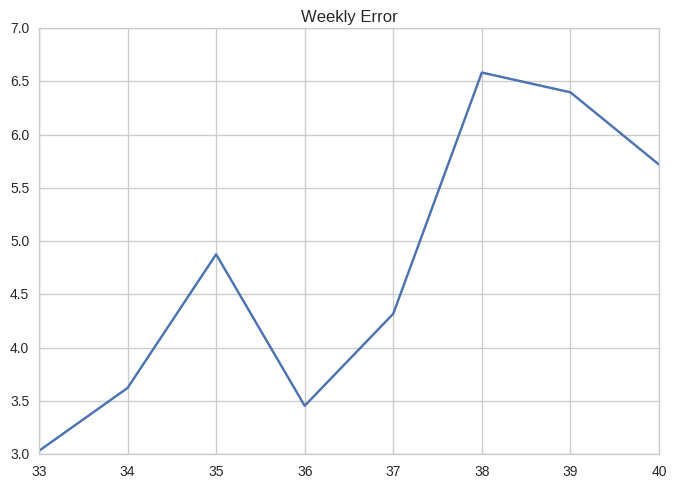

In [222]:
error, results = benchmark_full(*NO2_FEATURES)
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
plt.show()

# Making functions for other boards

In [223]:
def get_functions(name):
    data = pd.read_csv(DATA_DIR / "csv" / name, index_col='datetime', parse_dates=True)
    co_classifier = Pipeline([('poly', PolynomialFeatures(3)), ('cf', Lasso())])
    co_classifier.fit(data[CO_FEATURES[0]], data[CO_FEATURES[1]])
    print("CO")
    print("===========")
    print_function((None, None, co_classifier, CO_FEATURES[0]))
    print()
    
    o3_classifier = Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])
    o3_classifier.fit(data[O3_FEATURES[0]], data[O3_FEATURES[1]])
    print("O3")
    print("===========")
    print_function((None, None, o3_classifier, O3_FEATURES[0]))
    print()
    
    no2_classifier = Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])
    no2_classifier.fit(data[NO2_FEATURES[0]], data[NO2_FEATURES[1]])
    print("NO2")
    print("===========")
    print_function((None, None, no2_classifier, NO2_FEATURES[0]))
    print()

In [224]:
get_functions("B2.csv")

CO
f(x) = 1.28E-06 * co-A^2 + -1.06E-09 * co-W^2 + -1.89E-07 * co-W * temperature + 1.02E-07 * co-W * humidity + 3.10E-09 * co-A^3 + -1.98E-09 * co-A^2 * co-W + 9.05E-11 * co-A^2 * temperature + -3.84E-08 * co-A^2 * humidity + -3.87E-11 * co-A * co-W^2 + 4.13E-09 * co-A * co-W * temperature + -7.39E-09 * co-A * co-W * humidity + 2.14E-09 * co-A * temperature^2 + -3.11E-08 * co-A * temperature * humidity + -4.57E-08 * co-A * humidity^2 + -1.75E-12 * co-W^3 + 1.75E-11 * co-W^2 * temperature + 4.76E-11 * co-W^2 * humidity + -9.16E-10 * co-W * temperature^2 + 3.71E-09 * co-W * temperature * humidity + 1.96E-08 * co-W * humidity^2 + 3.95E-08 * temperature^2 * humidity + 6.76E-08 * temperature * humidity^2 + 2.55E-07 * humidity^3

O3
f(x) = -7.86E-03 * o3-W + 2.69E-03 * co-W + 6.69E-05 * o3-A^2 + -4.98E-05 * o3-A * o3-W + -7.19E-05 * o3-A * co-A + -2.17E-05 * o3-A * co-W + -6.77E-05 * o3-A * temperature + 2.65E-04 * o3-A * humidity + 4.21E-05 * o3-W^2 + -2.24E-05 * o3-W * co-A + 1.50E-05 * o

In [225]:
get_functions("B5.csv")

CO
f(x) = 4.76E-07 * co-A * co-W + 1.13E-09 * co-W^2 + -2.81E-07 * co-A^3 + -7.94E-09 * co-A^2 * co-W + 5.15E-07 * co-A^2 * temperature + 2.23E-08 * co-A^2 * humidity + -1.15E-11 * co-A * co-W^2 + 6.97E-09 * co-A * co-W * temperature + -1.89E-09 * co-A * co-W * humidity + 4.33E-07 * co-A * temperature * humidity + 2.32E-07 * co-A * humidity^2 + 2.04E-13 * co-W^3 + -1.89E-12 * co-W^2 * temperature + -6.33E-12 * co-W^2 * humidity + 2.03E-09 * co-W * temperature^2 + -1.18E-09 * co-W * temperature * humidity + -5.98E-10 * co-W * humidity^2 + -1.83E-07 * humidity^3

O3
f(x) = -2.60E-03 * co-W + 8.60E-04 * o3-A^2 + -1.72E-04 * o3-A * o3-W + 3.59E-05 * o3-A * co-A + -5.71E-08 * o3-A * co-W + -6.90E-05 * o3-W^2 + 5.42E-05 * o3-W * co-A + -4.17E-07 * o3-W * co-W + -8.62E-05 * o3-W * humidity + -2.44E-05 * co-A^2 + 3.69E-07 * co-A * co-W + 7.00E-09 * co-W^2 + -9.25E-09 * co-W * temperature + -3.01E-07 * co-W * humidity

NO2
f(x) = -7.10E-04 * co-W + 1.79E-04 * o3-A * o3-W + 6.18E-06 * o3-A * no2

In [226]:
get_functions("B8.csv")

CO
f(x) = -4.42E-07 * co-A^2 + -4.37E-07 * co-A * co-W + 1.90E-06 * co-A * temperature + -1.51E-07 * co-W^2 + -9.61E-07 * co-W * temperature + 1.27E-05 * co-W * humidity + -1.51E-11 * co-A^3 + 1.15E-10 * co-A^2 * co-W + -2.86E-10 * co-A^2 * temperature + 2.87E-09 * co-A^2 * humidity + 2.03E-10 * co-A * co-W^2 + -4.81E-09 * co-A * co-W * temperature + 9.84E-09 * co-A * co-W * humidity + 2.08E-08 * co-A * temperature^2 + -3.88E-08 * co-A * temperature * humidity + -1.47E-07 * co-A * humidity^2 + 2.47E-10 * co-W^3 + -4.54E-09 * co-W^2 * temperature + -1.14E-08 * co-W^2 * humidity + 2.53E-08 * co-W * temperature^2 + 1.24E-07 * co-W * temperature * humidity + 5.66E-08 * co-W * humidity^2 + -4.02E-08 * temperature^3 + -1.52E-07 * temperature^2 * humidity + -1.05E-07 * temperature * humidity^2 + 7.34E-07 * humidity^3

O3
f(x) = -3.21E-03 * o3-A^2 + 2.85E-03 * o3-A * o3-W + 6.97E-04 * o3-A * co-A + 1.60E-04 * o3-A * co-W + 5.83E-04 * o3-A * temperature + -1.95E-03 * o3-A * humidity + -1.97E-04

In [227]:
get_functions("B9.csv")

CO
f(x) = 9.37E-06 * co-A^2 + 6.09E-06 * co-A * co-W + -1.96E-04 * co-A * temperature + 5.38E-05 * co-A * humidity + -1.27E-07 * co-W^2 + 1.00E-05 * co-W * humidity + -3.01E-05 * humidity^2 + -1.35E-09 * co-A^3 + -4.40E-09 * co-A^2 * co-W + -7.11E-08 * co-A^2 * temperature + -6.14E-08 * co-A^2 * humidity + -9.04E-11 * co-A * co-W^2 + -1.29E-07 * co-A * co-W * temperature + -5.19E-08 * co-A * co-W * humidity + 4.20E-06 * co-A * temperature^2 + -1.28E-06 * co-A * temperature * humidity + 1.09E-07 * co-A * humidity^2 + -2.63E-11 * co-W^3 + 5.45E-10 * co-W^2 * temperature + 2.89E-08 * co-W^2 * humidity + -5.38E-07 * co-W * temperature^2 + 1.89E-06 * co-W * temperature * humidity + -8.66E-07 * co-W * humidity^2 + 4.04E-07 * temperature^3 + -2.10E-05 * temperature^2 * humidity + 3.82E-06 * temperature * humidity^2 + 5.37E-07 * humidity^3

O3
f(x) = -6.03E-02 * o3-A + -5.17E-01 * co-A + -1.04E-01 * co-W + -8.70E-01 * humidity + 2.08E-05 * o3-A^2 + 2.85E-05 * o3-A * o3-W + -3.38E-03 * o3-A * c

In [228]:
get_functions("B10.csv")

CO
f(x) = 1.73E-06 * co-A^2 + 2.75E-07 * co-A * co-W + -1.51E-06 * co-A * humidity + 2.91E-07 * co-W^2 + 3.64E-05 * co-W * humidity + -3.29E-05 * humidity^2 + -3.80E-10 * co-A^3 + -2.12E-11 * co-A^2 * co-W + 1.44E-09 * co-A^2 * temperature + 4.96E-09 * co-A^2 * humidity + -1.52E-10 * co-A * co-W^2 + -1.90E-08 * co-A * co-W * temperature + 1.17E-08 * co-A * co-W * humidity + 7.21E-08 * co-A * temperature^2 + 4.84E-07 * co-A * temperature * humidity + -3.03E-07 * co-A * humidity^2 + 3.38E-10 * co-W^3 + -4.25E-08 * co-W^2 * temperature + -2.91E-08 * co-W^2 * humidity + -1.80E-06 * co-W * temperature^2 + 4.08E-06 * co-W * temperature * humidity + -6.07E-07 * co-W * humidity^2 + 9.22E-06 * temperature^3 + -1.14E-05 * temperature^2 * humidity + -2.03E-05 * temperature * humidity^2 + 5.32E-06 * humidity^3

O3
f(x) = -2.88E-02 * co-W + -8.53E-04 * o3-A^2 + 3.92E-04 * o3-A * o3-W + -3.23E-04 * o3-A * co-A + -1.39E-05 * o3-A * co-W + 1.31E-02 * o3-A * temperature + -1.66E-03 * o3-A * humidity + 